In [1]:
import numpy as np
import tifffile as tf
import ntpath
import os
import matplotlib.pyplot as plt
import sys
import time
import math
from paq2py import *
from parse_markpoints import ParseMarkpoints
from utils import *
import seaborn as sns
from random import randint
from scipy import stats


%matplotlib inline 

In [2]:
paq_path = r'/home/jamesrowland/Desktop/s2/2019-03-05_RL025_003.paq'
s2p_path = r'/home/jamesrowland/Desktop/s2/artifactRemoved/suite2p'

In [3]:
paq = paq_read(paq_path)

arr = s2p_loader(s2p_path)
arr = dfof(arr)

arr.shape

(138, 1942)

In [4]:
naparm_path = r'/home/jamesrowland/Desktop/s2/2019-03-05_RL025_NAPARM_002'
xml_path = next(os.path.join(naparm_path, file) for file in os.listdir(naparm_path) if file.endswith('.xml'))
gpl_path = next(os.path.join(naparm_path, file) for file in os.listdir(naparm_path) if file.endswith('.gpl'))

In [5]:
clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

#digitise frame clock, two clocks should not occur less than 10ms apart or more than 100ms apart
frame_clock = digitise_trigger(clock_voltage, min_time = 0.01*paq['rate'], max_time = 0.1*paq['rate'])


In [6]:
m2p_idx = paq['chan_names'].index('markpoints2packio')
m2p_volts = paq['data'][m2p_idx, :]

#stims should not occur within 1ms of each other
stim_times = digitise_trigger(m2p_volts, min_time = 0.001*paq['rate'])

markpoints = ParseMarkpoints(xml_path=xml_path, gpl_path=gpl_path)
assert len(stim_times) == int(markpoints.iterations)

In [7]:
# assume all group durations the same
single_duration = float(markpoints.durations[0]) #ms
repetitions = float(markpoints.repetitions[0])
n_groups = len(markpoints.durations)
duration_ms = single_duration * repetitions * n_groups
duration_samples = (duration_ms / 1000) * paq['rate']

In [8]:
#use this to remove frames during stim based on paq
to_remove = []

for stim in stim_times:

    #the sample time of the frame immediately preceeding stim
    stim_start_frame = next(frame_clock[i-1] for i,sample in enumerate(frame_clock) if sample - stim > 0)

    # frame indexes that fall during the stim
    in_stim = np.where((frame_clock >= stim_start_frame) & (frame_clock <= stim + duration_samples))[0]
    
    in_stim = np.append(in_stim, in_stim[-1] + 1)
    in_stim = np.append(in_stim, in_stim[-1] + 1)
    
    [to_remove.append(f) for f in in_stim]
    
# arr[:, to_remove] = np.nan

In [9]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim > 0)
    
    stim_start_frames.append(stim_start_frame)
    
assert len(stim_start_frames) == int(markpoints.iterations)

stim_start_frames = np.array(stim_start_frames)
assert max(stim_start_frames) < arr.shape[1]


In [10]:
pre_frames = 50
post_frames = 50

all_trials = []
stas = []
dfs = []
t_tests = []

count = 0
    
for i, unit in enumerate(arr):

    trials = []
    df = []
    
    # observations before stim
    pre_obs = []
    #observations after stim
    post_obs = []

    for stim in stim_start_frames:
        
        pre_stim  = unit[stim-10: stim-5]
        post_stim = unit[stim +10: stim + 15]
        
        pre_mean = np.mean(pre_stim)
        post_mean = np.mean(post_stim)
        df.append(post_mean - pre_mean)

        [pre_obs.append(ob) for ob in pre_stim]
        [post_obs.append(ob) for ob in post_stim]
                          
        trial = unit[stim-pre_frames : stim+post_frames]
        #trial = dfof(trial)
        trials.append(trial)
  
    trials = np.array(trials)
    all_trials.append(trials)

    sta = np.mean(trials, 0)        
    stas.append(sta)
    
    dfs.append(np.mean(df))
    
    t_test = stats.ttest_ind(pre_obs, post_obs)
    t_tests.append(t_test)
         
    if t_test[1] < 0.05:
        print(t_test[1])
        print(i)
        count += 1
        
 
dfs = np.array(dfs)
stas = np.array(stas)
all_trials = np.array(all_trials)
   


0.015509508917180089
2
0.02756189517257936
19
0.010628572287524793
33
0.04045024991842965
35
0.0007221655406949855
39
0.006909411632932803
63
0.025685992620562953
70
0.04125984494457987
73
0.04697354725517775
78
0.038766792690897736
81
0.01913587001757532
91
0.008385794832679191
96
0.041613988268829394
111
0.04911573378339167
116
0.014927211500830553
125
0.034059497710290876
135


In [14]:
count

16

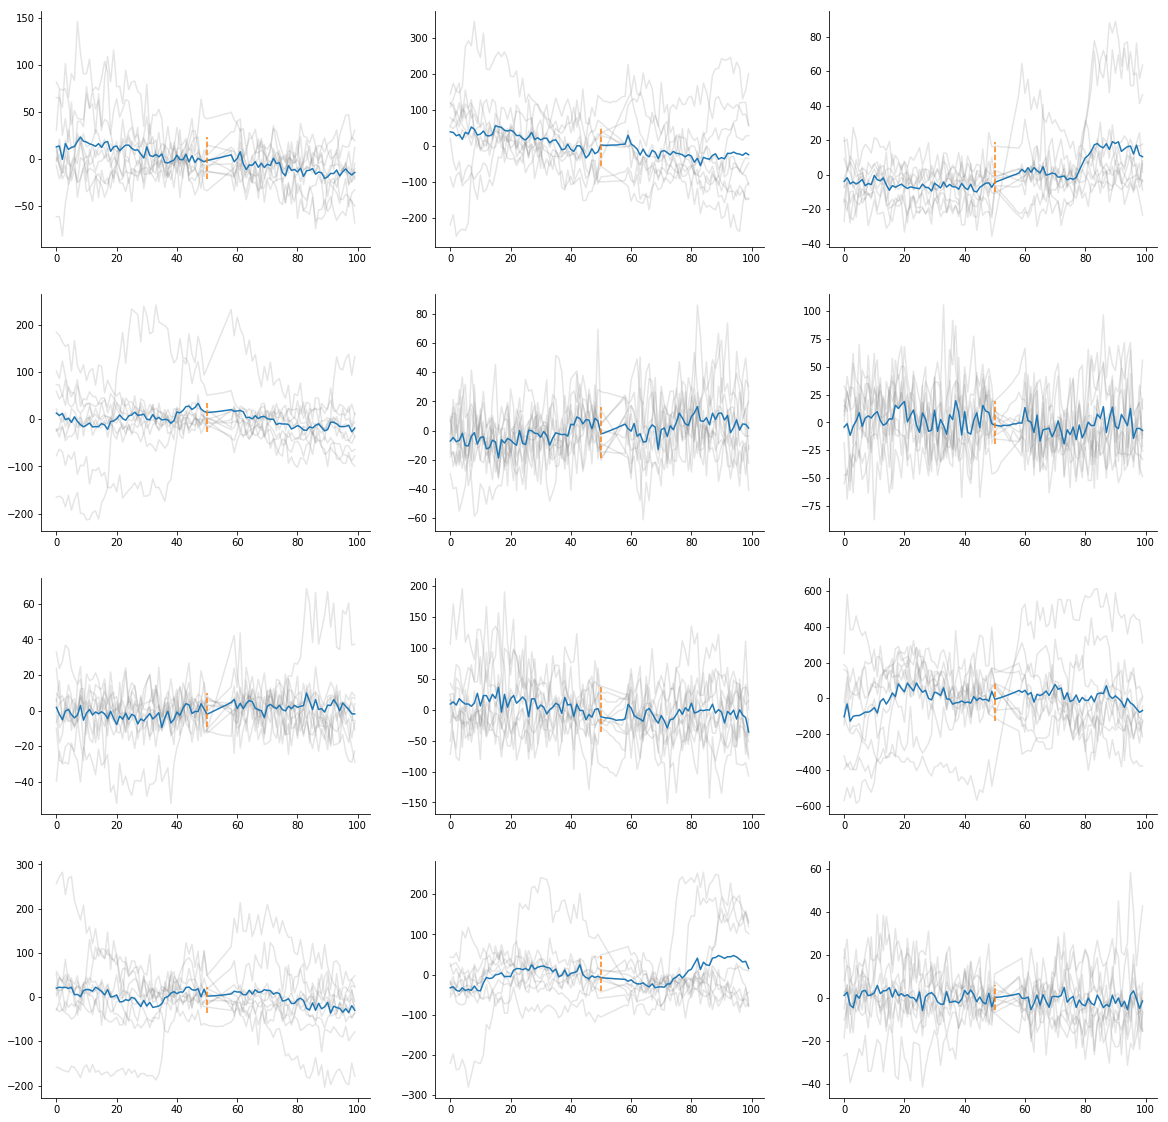

In [12]:
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    sta = stas[i]
    [plt.plot(t, c='grey', alpha=0.2) for t in all_trials[i,:,:]]
    plt.plot(sta)
    plt.plot([pre_frames] * 100, np.linspace(min(sta), max(sta), 100), '--')
    #plt.ylim([min(sta)-0.3*min(sta), max(sta)+0.3*max(sta)])
sns.despine()

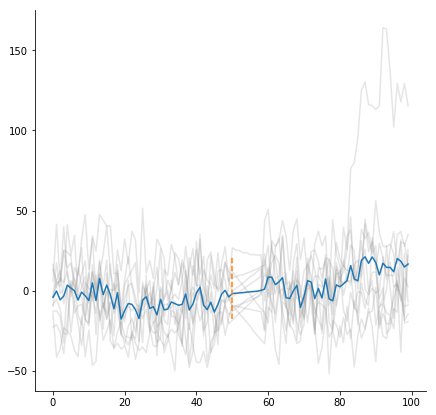

In [13]:
unit = 96
plt.figure(figsize=(7,7))
sta = stas[unit]
[plt.plot(t, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
plt.plot(sta)
plt.plot([pre_frames] * 100, np.linspace(min(sta), max(sta), 100), '--')
sns.despine()